# Caravan Insurance
## Assignment 1

**Loading the Packages**

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
import os
# Classify with Logistic Regression.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

* **Loading the dataset and minor preprocessing**

Extracting the column names of our independent variables from the dictionary file. 

In [93]:
import pdb
column_file = 'tic/dictionary.txt'
#fhand = open(attrFile)
colNames = []
with open(column_file,'r',encoding='utf8',errors='ignore') as fhand:
    count=0
    for line in fhand :
        count+=1
        vstr = line.split(' ')
        if len(vstr)>2:
            colNames.append(vstr[1])
colNames = colNames[1:87]


In [3]:
colNames = np.array(colNames)

**Loading the Train and test data.**

In [94]:
train_data = pd.read_csv('tic/ticdata2000.txt', header = None,sep= '\t',names=colNames )
test_data = pd.read_csv('tic/ticeval2000.txt', header = None,sep= '\t' ,names=colNames)
test_data = pd.read_csv('tic/ticeval2000.txt', header = None,sep= '\t',names=colNames[:85] )
colname= ["CARAVAN"]
y_test_data = pd.read_csv('tic/tictgts2000.txt',names=colname)


Splitting the Train data to the target variable and the data frame of independent variable for ease of use and easy visualization of the dataset

In [95]:
x_train_data = train_data.drop(columns="CARAVAN")
y_train_data = train_data["CARAVAN"]
x_test_data = test_data


Summary of Training Data
Below Table describe some of the key statistics such as mean Standar Deviation min-max of our independent Variables


Checking Whether if there are any Null values in our tranining set. As can be seen in the code below that we have no null value in our dataset.

In [96]:
train_data.isnull().sum().sum()

0

Seeing the distribution of our target variable. As can be seen below the ratio of total number of custmer with no insurance vs customer with insurance is nearly 16:1. Hence our data is very imbalanced. So going forward during our processing we will have to oversample our data for better training and learning and also use the necessary metrics to judge the accuracy of model.

In [97]:
y_train_data.value_counts()

0    5474
1     348
Name: CARAVAN, dtype: int64

## Data Exploration


###  Summary of Our Dataset

Some basic summary of our Independent Variable such as **Standard Deviation, Mean, Min,Max etc..**   

In [98]:
x_train_data.describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,...,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,24.253349,1.110615,2.678805,2.991240,5.773617,0.696496,4.626932,1.069907,3.258502,6.183442,...,0.076606,0.005325,0.006527,0.004638,0.570079,0.000515,0.006012,0.031776,0.007901,0.014256
std,12.846706,0.405842,0.789835,0.814589,2.856760,1.003234,1.715843,1.017503,1.597647,1.909482,...,0.377569,0.072782,0.080532,0.077403,0.562058,0.022696,0.081632,0.210986,0.090463,0.119996
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,1.000000,3.000000,3.000000,7.000000,0.000000,5.000000,1.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,2.000000,4.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,10.000000,5.000000,6.000000,10.000000,9.000000,9.000000,5.000000,9.000000,9.000000,...,8.000000,1.000000,1.000000,2.000000,7.000000,1.000000,2.000000,3.000000,2.000000,2.000000


### **Correlation Matrix** of our dataset

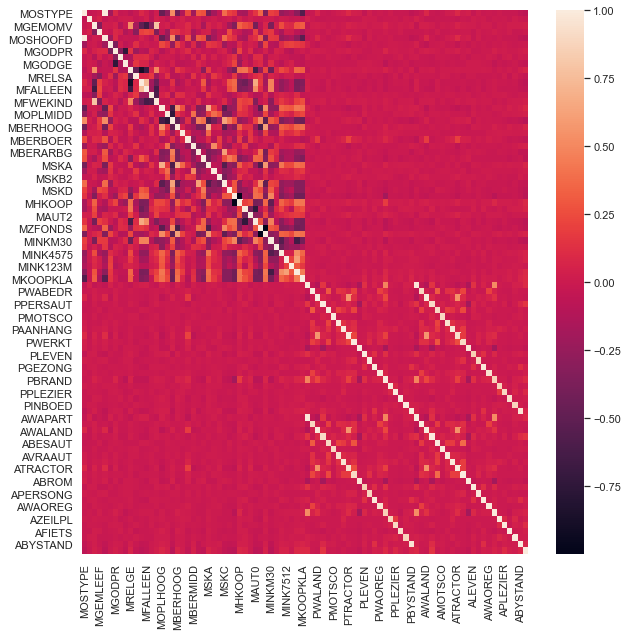

In [99]:
corr = train_data.corr()
vind = np.where(abs(corr)>.7)
vind = [(colNames[train_data.index[x]],colNames[train_data.index[y]]) for x,y in zip(*vind) if x!=y and x<y]
plt.figure(figsize = (10,10))
sns.heatmap(corr)

In [100]:
vind2=[]
for i in range(len(vind)):
    if vind[i][0][-4:] != vind[i][1][-4:]:
        vind2.append(vind[i])
print(vind2)

[('MOSTYPE', 'MOSHOOFD'), ('MGEMOMV', 'MFWEKIND'), ('MGODPR', 'MGODGE'), ('MRELGE', 'MRELOV'), ('MRELOV', 'MFALLEEN'), ('MOPLMIDD', 'MOPLLAAG'), ('MHHUUR', 'MHKOOP'), ('MAUT1', 'MAUT0'), ('MZFONDS', 'MZPART')]


### Histogram of Independent Variable

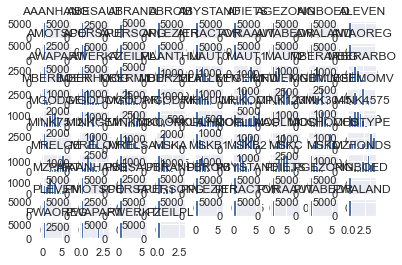

In [101]:
x_train_data.hist()
plt.show()
plt.rcParams['figure.figsize'] = [50,50]

In [12]:
def plot_features(key,value):
    a=train_data.pivot(columns = 'CARAVAN',values = key).plot.hist(color=['darkkhaki','salmon'],stacked = True,bins=10)
    plt.grid(color='#95a5a6',linestyle='--', linewidth=1,axis='y',alpha=0.4)  
    plt.grid(color='#95a5a6',linestyle='--', linewidth=1,axis='x',alpha=0)
    plt.xlabel(value)
    plt.ylabel("count")
    plt.title(value)
    plt.rcParams['figure.figsize'] = [10,10]

Below are some of the plot of Features with our target variable based on intuition(i.e on the feeling that it might have some relation with customer who have bought the insurance or not

### Plot on the basis of High Level Education

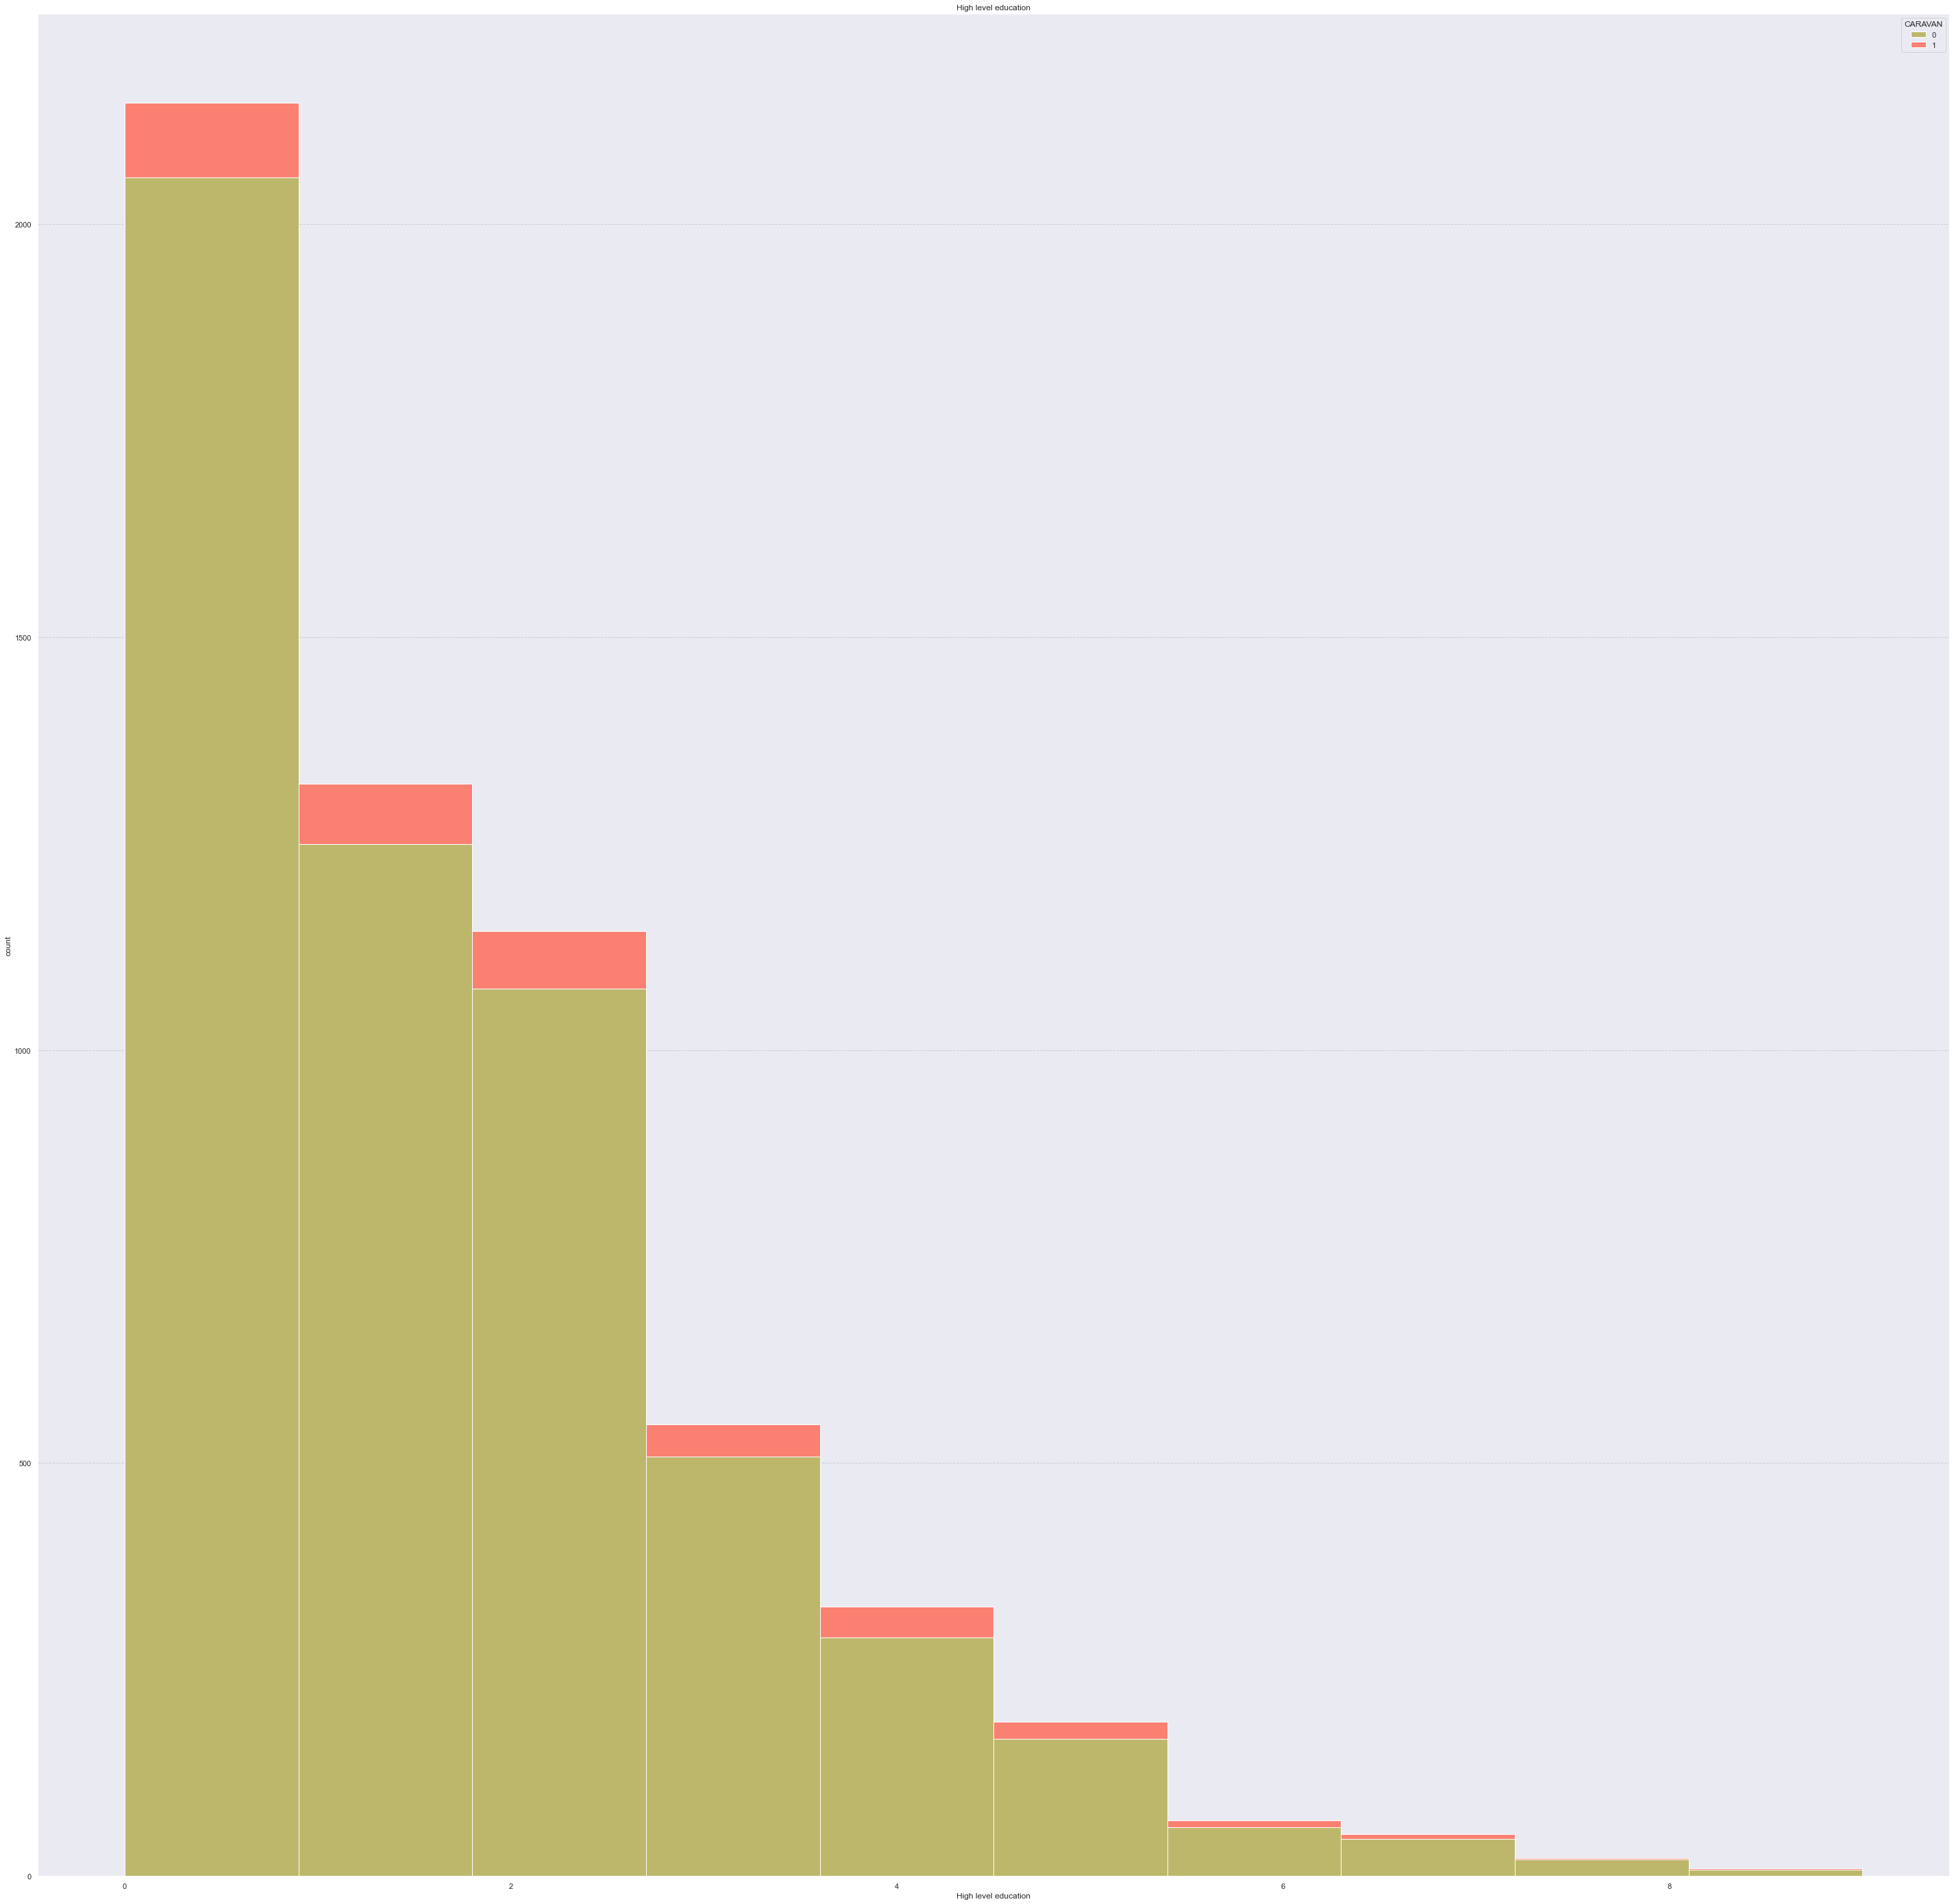

In [13]:
plot_features('MOPLHOOG',"High level education")

### Plot on the basis of Number of Houses

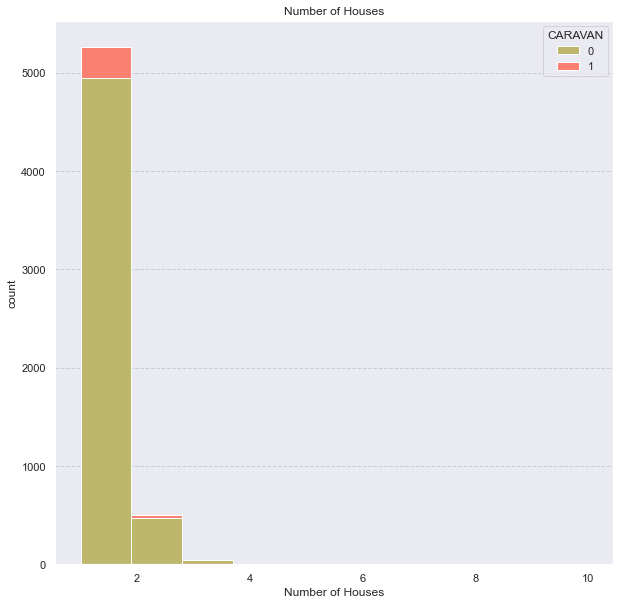

In [14]:
plot_features('MAANTHUI',"Number of Houses")

### Plot on the basis of Customer Subtype

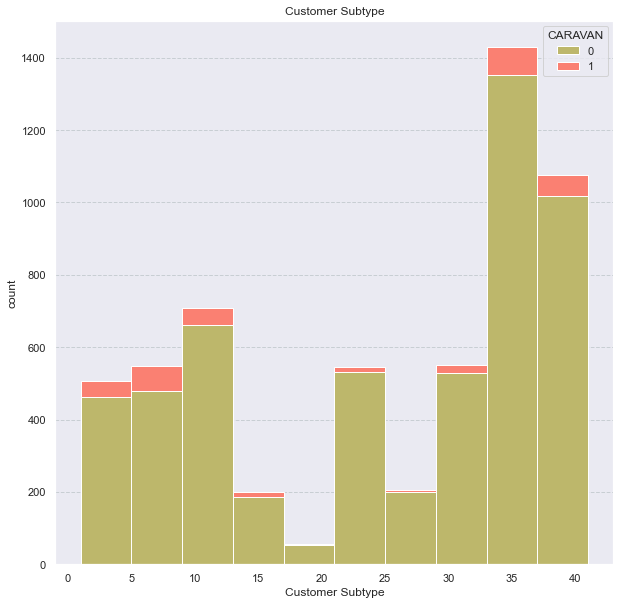

In [15]:
plot_features('MOSTYPE',"Customer Subtype")

### Plot on the basis of Average Age

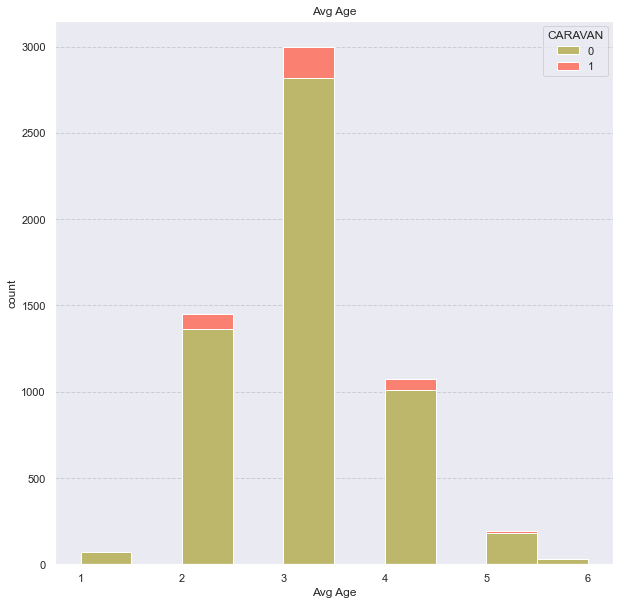

In [16]:
plot_features('MGEMLEEF',"Avg Age")

### Plot on the basis of Average Income

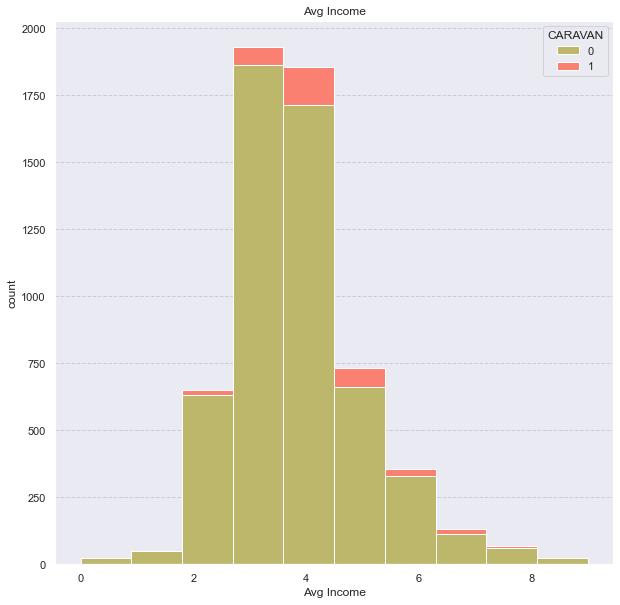

In [17]:
plot_features('MINKGEM',"Avg Income")

## Feature Selection

Below i have used Random Forest Classifier to rank the most ten most important features out of given 85 features i have made plot of some of those featues below and also used these selected features while training the model

Initialization of Random forest Classifier and fitting the model.

In [18]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train_data,y_train_data)
vPrediction = model_rf.predict(x_test_data)

In [19]:
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
vRank_to_use= 15
feature_selection = np.array(colNames)[indices[:vRank_to_use]]
print(feature_selection)


['PBRAND' 'APERSAUT' 'PPERSAUT' 'MOSTYPE' 'PWAPART' 'MKOOPKLA' 'MOSHOOFD'
 'MBERMIDD' 'ABRAND' 'AWAPART' 'MFWEKIND' 'MOPLLAAG' 'MFGEKIND' 'MINK3045'
 'MGODGE']


Some of the ranked features generated by the Random Forest classifier are mentioned below along with there description. 

Apart from some of the features for which i made the plot on the basis of intuition there are some features which although don't make much sense but were ranked very highly by the model.Some of these features are such as:
* **Contribution of Fire policy**
* **Purchasing power class**
* **Contribution private third party insurance**
* **Number of fire policies**


Although the purchasing power class makes intuitive sense as people with money can afford caravan and also the insurance but having fire policy or contribution of 3rd party insurance seems un-intuitive. Below i have made plots of these features. 

In [20]:
vfeature = {'PBRAND':"Contribution fire policies" ,'PPERSAUT':"Contribution car policies", 'APERSAUT':"Number of car policies",'PWAPART':"Contribution private third party insurance", 'MKOOPKLA':"Purchasing power class", 'MOSHOOFD':"Customer main type",'ABRAND':"Number of fire policies"}

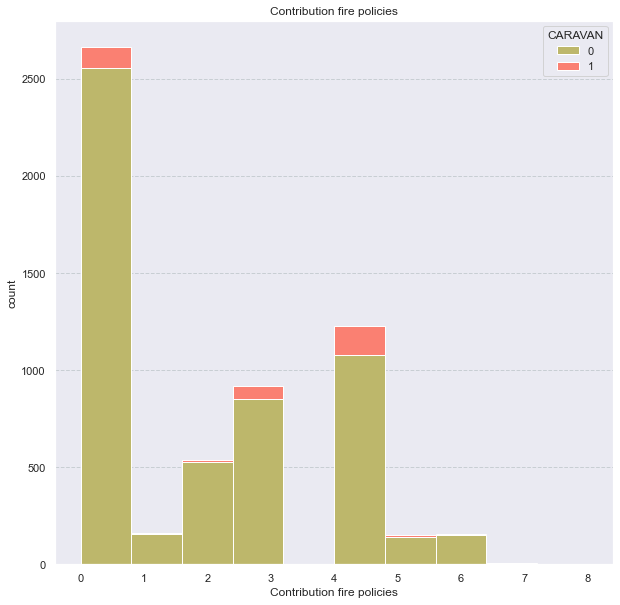

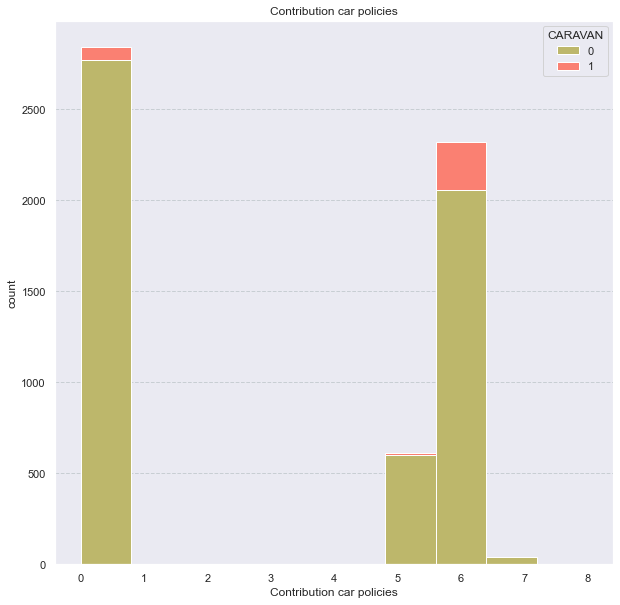

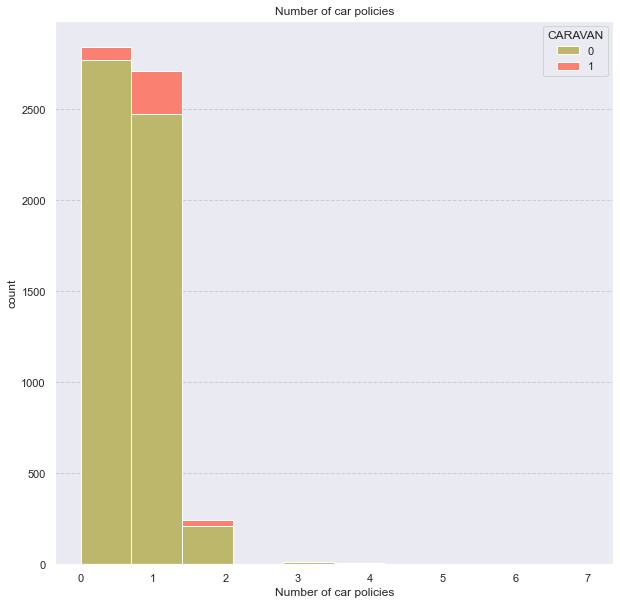

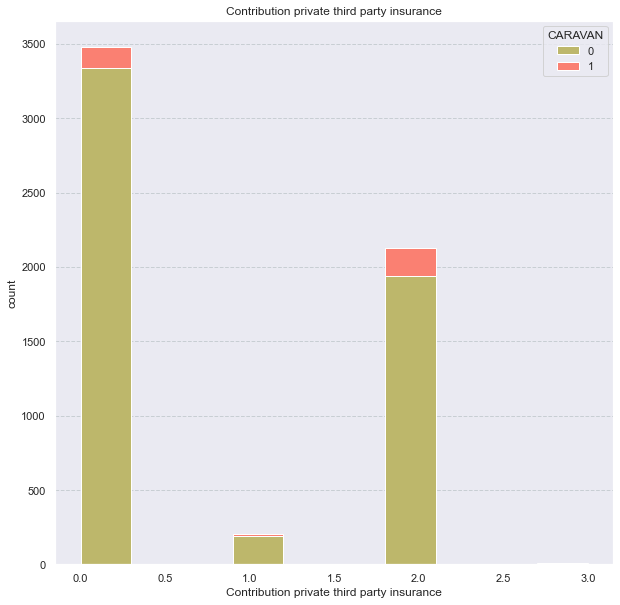

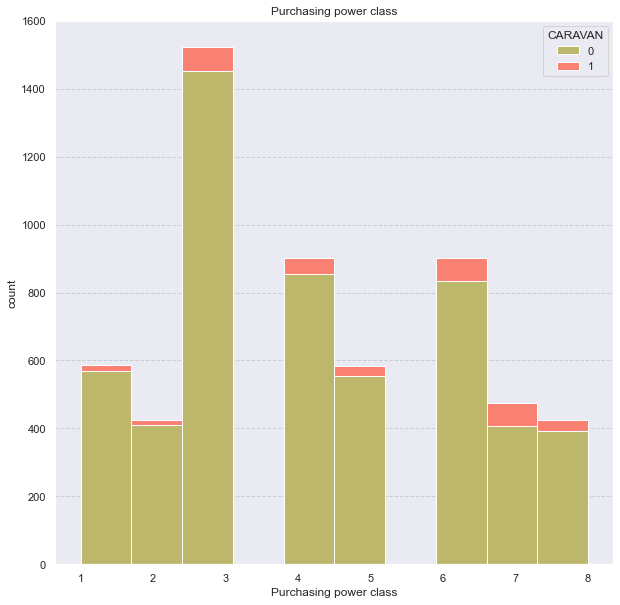

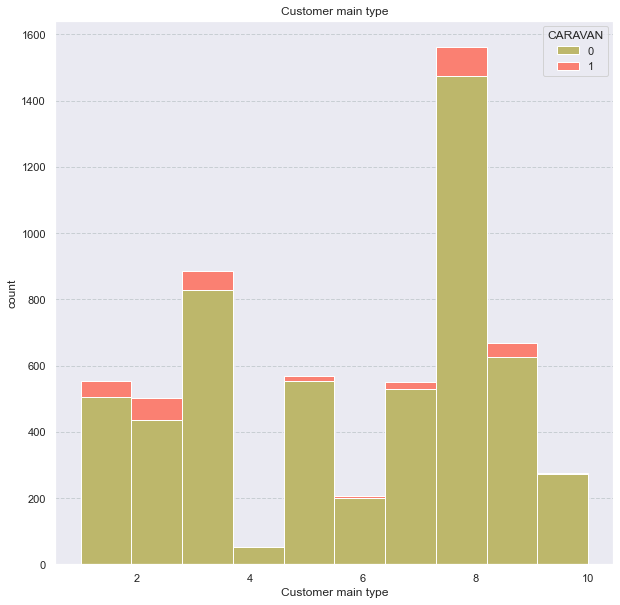

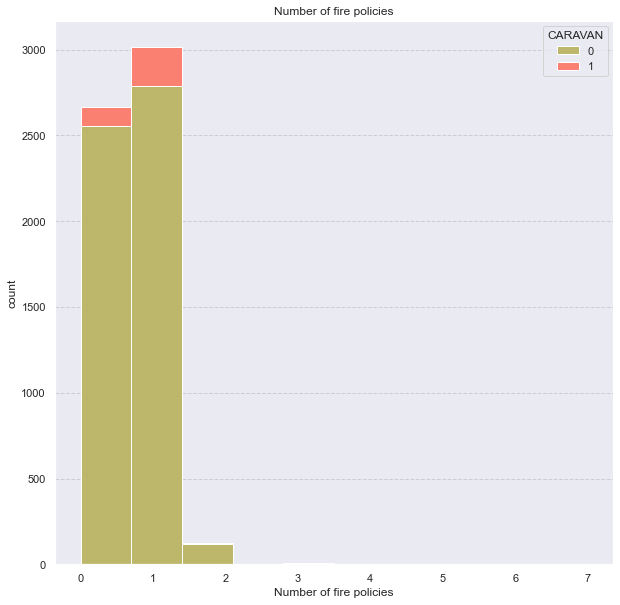

In [21]:
for key in vfeature:
    plot_features(key,vfeature[key])

## Normalizing the data


Below i am scaling the data as is generally advised before we train our model 

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_data = scaler.fit_transform(x_train_data)
x_test_data = scaler.transform(x_test_data)

### **Creating train and test data for selected features.**

In [23]:
x_train_selected = x_train_data[:,indices[:vRank_to_use]]
x_test_selected =  x_test_data[:,indices[:vRank_to_use]]

### **Using Oversampling on our featurs to train our model**

As was discussed previously our given training data is very highly imbalanced so i am using the SMOTE(Synthetic Minority Oversampling Technique) function from the **imblearn** package to oversample our data

While training i have trained our model on different Algorithm and on both the original data and oversampled data.

In [24]:
x_train_over, y_train_over = SMOTE().fit_sample(x_train_data, y_train_data)
print('Training Set Shape after oversampling:   ', x_train_over.shape, y_train_over.shape)


Training Set Shape after oversampling:    (10948, 85) (10948,)


## Model Prediction and Evaluation

### **Logistic Regression**
* **On Complete train dataset**

In [25]:
parameters = {'solver': ['newton-cg','lbfgs', 'liblinear', 'sag']}
lr = LogisticRegression(max_iter=2000)
lr_search = GridSearchCV(lr, parameters)
lr_search.fit(x_train_data,y_train_data)
best_lr = lr_search.best_estimator_
lr_search
lr_search.fit(x_train_data, y_train_data)

/Users/sanchit/da2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanchit/da2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanchit/da2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanchit/da2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=2000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [26]:
y_hat_lr = best_lr.predict(x_test_data)
y_hat_proba = best_lr.predict_proba(x_test_data)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [27]:
print("The Confusion Matrix is: \n")
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print("The Area under the cuve is {}".format(lr_roc_auc))

The Confusion Matrix is: 

[[   3  235]
 [   5 3757]]
The Area under the cuve is 0.7255248191780701


In [28]:
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.94


* **Running the same model on top 15 ranked features**

In [29]:
parameters = {'solver': ['newton-cg', 'liblinear', 'sag']}
lr = LogisticRegression()
clf_lr = GridSearchCV(lr, parameters, cv=10)
clf_lr.fit(x_train_selected, y_train_data)
best_lr = clf_lr.best_estimator_
best_lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
y_hat_lr = best_lr.predict(x_test_selected)
y_hat_proba = best_lr.predict_proba(x_test_selected)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [31]:
print("The Confusion Matrix is: \n")
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print("The Area under the cuve is {}".format(lr_roc_auc))

The Confusion Matrix is: 

[[   0  238]
 [   0 3762]]
The Area under the cuve is 0.709450207515223


In [32]:
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.9405


* **Running the same mode on Oversampled Data**

In [33]:
lr = LogisticRegression()
parameters = {'solver': ['newton-cg', 'liblinear', 'sag']}
clf_lr = GridSearchCV(lr, parameters, cv=10)
clf_lr.fit(x_train_over, y_train_over)
best_lr = clf_lr.best_estimator_
best_lr

/Users/sanchit/da2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanchit/da2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanchit/da2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanchit/da2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanchit/da2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
y_hat_lr = best_lr.predict(x_test_data)
y_hat_proba = best_lr.predict_proba(x_test_data)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [35]:
print("The Confusion Matrix is: \n")
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print("The Area under the cuve is {}".format(lr_roc_auc))

The Confusion Matrix is: 

[[ 137  101]
 [1074 2688]]
The Area under the cuve is 0.7069243965528795


In [36]:
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.70625


**Training the Oversample model on data with selected features**

In [37]:
parameters = {'solver': ['newton-cg', 'liblinear', 'sag']}
lr = LogisticRegression()
clf_lr = GridSearchCV(lr, parameters, cv=10)
clf_lr.fit(x_train_over[:,indices[:vRank_to_use]], y_train_over)
best_lr = clf_lr.best_estimator_
best_lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
y_hat_lr = best_lr.predict(x_test_selected)
y_hat_proba = best_lr.predict_proba(x_test_selected)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [39]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)

[[ 146   92]
 [1269 2493]]
0.7080049723238577


In [40]:
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.65975


### Naive Bayes Classifier

**Using the Naive Bayes Classifier on the whole dataset**

In [41]:
from sklearn.naive_bayes import BernoulliNB
clf_NB = BernoulliNB()
clf_NB.fit(x_train_data, y_train_data)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [42]:
y_hat_lr = clf_NB.predict(x_test_data)
y_hat_proba = clf_NB.predict_proba(x_test_data)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [43]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])

[[  88  150]
 [ 580 3182]]
0.6859377722380818


In [44]:
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.8175


**Using the Naive Bayes Classifier on our Oversampled data**

In [45]:
from sklearn.naive_bayes import BernoulliNB
clf_NB = BernoulliNB()
clf_NB.fit(x_train_data, y_train_data)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [46]:
y_hat_lr = clf_NB.predict(x_test_data)
y_hat_proba = clf_NB.predict_proba(x_test_data)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [47]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])

[[  88  150]
 [ 580 3182]]
0.6859377722380818


In [48]:
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.8175


**Using the Naive Bayes Classifier on top 15 selected Features**

In [49]:
from sklearn.naive_bayes import BernoulliNB
clf_NB = BernoulliNB()
clf_NB.fit(x_train_selected, y_train_data)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [50]:
y_hat_lr = clf_NB.predict(x_test_selected)
y_hat_proba = clf_NB.predict_proba(x_test_selected)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [51]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])

[[  54  184]
 [ 235 3527]]
0.6820443488400144


In [52]:
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.89525


**Using the Naive Bayes Classifier on our Oversampled data with selected Features**

In [53]:
from sklearn.naive_bayes import BernoulliNB
clf_NB = BernoulliNB()
clf_NB.fit(x_train_over[:,indices[:vRank_to_use]], y_train_over)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [54]:
y_hat_lr = clf_NB.predict(x_test_selected)
y_hat_proba = clf_NB.predict_proba(x_test_selected)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [55]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])

[[ 152   86]
 [1233 2529]]
0.6819851545083743


In [56]:
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.67025


[]

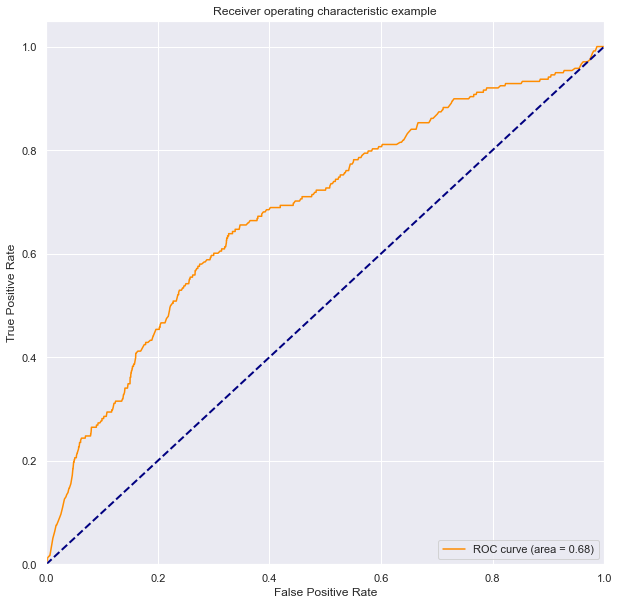

In [57]:
plt.plot(lr_fpr,lr_tpr,color='darkorange',label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.plot()

### **Random Forest Classifier**

* **On Complete train dataset**

In [58]:
clf_RF = RandomForestClassifier()

clf_RF.fit(x_train_data, y_train_data)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
y_hat_lr = clf_RF.predict(x_test_data)
y_hat_proba = clf_RF.predict_proba(x_test_data)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [60]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])

[[  14  224]
 [  51 3711]]
0.6842864737601579


In [61]:
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.93125


* **Running the same model on top 15 ranked features**

In [62]:
clf_RF = RandomForestClassifier()

clf_RF.fit(x_train_selected, y_train_data)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
y_hat_lr = clf_RF.predict(x_test_selected)
y_hat_proba = clf_RF.predict_proba(x_test_selected)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [64]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])

[[  16  222]
 [  44 3718]]
0.6656787914527852


In [65]:
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.9335


* **Running the Random Forest on OverSample Data**

In [66]:
clf_RF = RandomForestClassifier()

clf_RF.fit(x_train_over, y_train_over)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [67]:
y_hat_lr = clf_RF.predict(x_test_data)
y_hat_proba = clf_RF.predict_proba(x_test_data)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [68]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])

[[  19  219]
 [  87 3675]]
0.6761595387756377


In [69]:
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.9235


* **Running the same model on top 15 ranked features and oversampled data**

In [70]:
clf_RF = RandomForestClassifier()
clf_RF.fit(x_train_over[:,indices[:vRank_to_use]], y_train_over)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [71]:
y_hat_lr = clf_RF.predict(x_test_selected)
y_hat_proba = clf_RF.predict_proba(x_test_selected)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [72]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)

[[  21  217]
 [  72 3690]]
0.6627179579965958


In [73]:
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.92775


### **AdaBoost Classifier**

* **On Complete train dataset**

In [74]:
from sklearn.ensemble import AdaBoostClassifier
clf_ada = AdaBoostClassifier()

clf_ada.fit(x_train_data, y_train_data)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [75]:
y_hat_lr = clf_ada.predict(x_test_data)
y_hat_proba = clf_ada.predict_proba(x_test_data)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [76]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])

[[   4  234]
 [  11 3751]]
0.6968406980016886


In [77]:
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.93875


* **Running the same model on top 15 ranked features**

In [78]:
clf_ada = AdaBoostClassifier()

clf_ada.fit(x_train_selected, y_train_data)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [79]:
y_hat_lr = clf_ada.predict(x_test_selected)
y_hat_proba = clf_ada.predict_proba(x_test_selected)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [80]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])

[[   0  238]
 [   0 3762]]
0.7129164265387176


In [81]:
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.9405


* **Running the Random Forest on OverSample Data**

In [82]:
clf_ada = AdaBoostClassifier()

clf_ada.fit(x_train_over, y_train_over)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [83]:
y_hat_lr = clf_ada.predict(x_test_data)
y_hat_proba = clf_ada.predict_proba(x_test_data)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [84]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])

[[  50  188]
 [ 289 3473]]
0.6943601204437118


In [85]:
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.88075


* **Running the same model on top 15 ranked features and oversampled data**

In [86]:
clf_ada = AdaBoostClassifier()
clf_ada.fit(x_train_over[:,indices[:vRank_to_use]], y_train_over)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [87]:
y_hat_lr = clf_ada.predict(x_test_selected)
y_hat_proba = clf_ada.predict_proba(x_test_selected)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_data, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [88]:
print(confusion_matrix(y_test_data, y_hat_lr, labels=[1,0]))
print(lr_roc_auc)

[[  41  197]
 [ 250 3512]]
0.6515654108533365


In [89]:
yPred= confusion_matrix(y_test_data, y_hat_lr, labels=[1,0])
vAcc = (yPred[1][1] + yPred[0][0])/4000
print(vAcc)

0.88825


In [110]:
print(sum(y_test_data.values==1))
np.shape(y_test_data)

[238]


(4000, 1)